In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../Results/final_data.csv")

In [3]:
input_features = ['transformedRank1', 'careerMatches1', 'careerWin%1', 'surfaceWin%1', 'tiebreakerWin%1', 'deciderWin%1', 'wearOut1', 'transformedRank2', 'careerMatches1', 'careerWin%2', 'surfaceWin%2', 'tiebreakerWin%2', 'deciderWin%2', 'wearOut2', 'careerH2H', 'h2hWin%1']

X = np.array(data[input_features])
y = np.array(data["Upset"])
odds = data[["Odds1","Odds2"]]

In [4]:
# Train-Test split
X_train = torch.from_numpy(X[:10000])
X_test = torch.from_numpy(X[10000:])

y_train = torch.from_numpy(y[:10000])
y_test = torch.from_numpy(y[10000:])

In [5]:
### Initialze the network

input_size = 16
output_size = 2            # Player's winning probability and variance in its prediction

model = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(input_size,output_size),
    nn.Sigmoid()
)

print(model)


Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=16, out_features=2, bias=True)
  (2): Sigmoid()
)


In [7]:
def customLoss(y_pred,y):
    y_pred = torch.max(0.001*torch.ones_like(y_pred),y_pred)
    prob = y_pred[:,0].unsqueeze(1)
    var = y_pred[:,1].unsqueeze(1)
    # torch.mean(F.binary_cross_entropy(prob,y,reduction='none')/var + var)
    return  torch.mean(F.binary_cross_entropy(prob,y,reduction='none')/(100*var) + var)

criterion = customLoss
optimizer = torch.optim.Adam(model.parameters(),lr=1e-5)

In [8]:
n_epochs = 100

for epoch in range(n_epochs):
    for i in range(1000):
        predictions = model(X_train[i:i+10,:].float())
        targets = y_train[i:i+10].reshape(-1,1)
        loss = criterion(predictions, targets.detach().float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    y_pred = model(X_train.float())
    y_target = y_train.float()
    y_target = y_target.unsqueeze(1)
    train_loss = criterion(y_pred,y_target.detach().float()).item()

    y_pred = model(X_test.float())
    y_target = y_test.float()
    y_target = y_target.unsqueeze(1)
    test_loss = criterion(y_pred,y_target.detach().float()).item()

    print("Epoch {}: Training loss - {}, Testing loss - {}".format(epoch+1,train_loss,test_loss))

Epoch 1: Training loss - 1.5550718307495117, Testing loss - 3.1637768745422363
Epoch 2: Training loss - 2.1323790550231934, Testing loss - 3.612762928009033
Epoch 3: Training loss - 1.2186369895935059, Testing loss - 1.7532048225402832
Epoch 4: Training loss - 1.1990450620651245, Testing loss - 3.107952356338501
Epoch 5: Training loss - 1.5845732688903809, Testing loss - 3.105802297592163
Epoch 6: Training loss - 1.6735517978668213, Testing loss - 2.1603522300720215
Epoch 7: Training loss - 1.4679206609725952, Testing loss - 4.034562110900879
Epoch 8: Training loss - 1.4600242376327515, Testing loss - 4.030630588531494
Epoch 9: Training loss - 1.5576086044311523, Testing loss - 1.6962848901748657
Epoch 10: Training loss - 1.4533342123031616, Testing loss - 4.035204887390137
Epoch 11: Training loss - 1.5539348125457764, Testing loss - 5.454326629638672
Epoch 12: Training loss - 1.9470738172531128, Testing loss - 2.6241414546966553
Epoch 13: Training loss - 1.8466861248016357, Testing lo

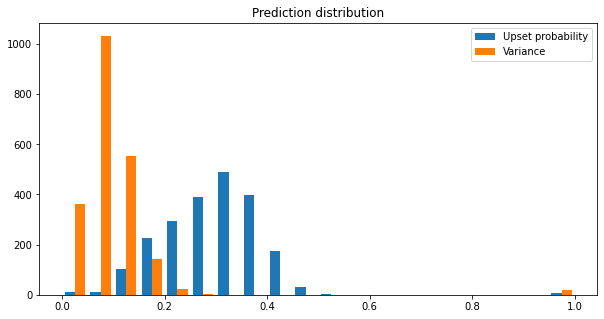

In [17]:
y_pred = model(X_test.float())
predictions = y_pred.detach().numpy()

plt.figure(figsize=(10,5))
plt.hist(predictions,bins=20)
plt.title("Prediction distribution")
plt.legend(["Upset probability","Variance"])
plt.show()

In [35]:
odds_test = odds[10000:].copy(deep=True)
odds_test = odds_test.reset_index()
odds_test.drop(columns=["index"],inplace=True)

final_data = pd.DataFrame()
final_data["Predicted prob"] = predictions[:,0]
final_data["Predicted variance"] = predictions[:,0]
final_data["Odds1"] = odds_test["Odds1"]
final_data["Odds2"] = odds_test["Odds2"]
final_data["Result"] = y_test

In [38]:
torch.save(model.state_dict(),"../Results/model_weights.pt")

In [39]:
final_data.to_csv("../Results/upset_probs.csv",index=None)